In [2]:
# Importação de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import inspect
import os
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
# Carregamento do dataset
dataset = pd.read_csv("../data/creditcard.csv")

# Converte todos os nomes de colunas para minúsculas
dataset.columns = dataset.columns.str.lower()

In [4]:
# Visualizar as primeiras 5 linhas do dataset
dataset.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
# Visualizar as Colunas do dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   time    284807 non-null  float64
 1   v1      284807 non-null  float64
 2   v2      284807 non-null  float64
 3   v3      284807 non-null  float64
 4   v4      284807 non-null  float64
 5   v5      284807 non-null  float64
 6   v6      284807 non-null  float64
 7   v7      284807 non-null  float64
 8   v8      284807 non-null  float64
 9   v9      284807 non-null  float64
 10  v10     284807 non-null  float64
 11  v11     284807 non-null  float64
 12  v12     284807 non-null  float64
 13  v13     284807 non-null  float64
 14  v14     284807 non-null  float64
 15  v15     284807 non-null  float64
 16  v16     284807 non-null  float64
 17  v17     284807 non-null  float64
 18  v18     284807 non-null  float64
 19  v19     284807 non-null  float64
 20  v20     284807 non-null  float64
 21  v21     28

In [6]:
# Estatísticas descritivas
# Mostra medidas como média, desvio padrão, mínimos, máximos e quartis das variáveis numéricas.
# Útil para entender a distribuição dos dados, detectar outliers e avaliar necessidade de normalização.

dataset.describe()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.175161e-15,3.384974e-16,-1.379537e-15,2.094852e-15,1.021879e-15,1.494498e-15,-5.620335e-16,1.149614e-16,-2.414189e-15,...,1.628620e-16,-3.576577e-16,2.618565e-16,4.473914e-15,5.109395e-16,1.686100e-15,-3.661401e-16,-1.227452e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [7]:
# Contagem de classes
# Mostra quantas transações pertencem a cada classe (0 = não fraude, 1 = fraude).
# Útil para verificar o desbalanceamento do dataset e entender a proporção de fraudes.

print(dataset['class'].value_counts())

class
0    284315
1       492
Name: count, dtype: int64


C:\Users\Aquiles\AppData\Local\Temp\ipykernel_22468\2060798267.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='class', data=dataset, palette="viridis")


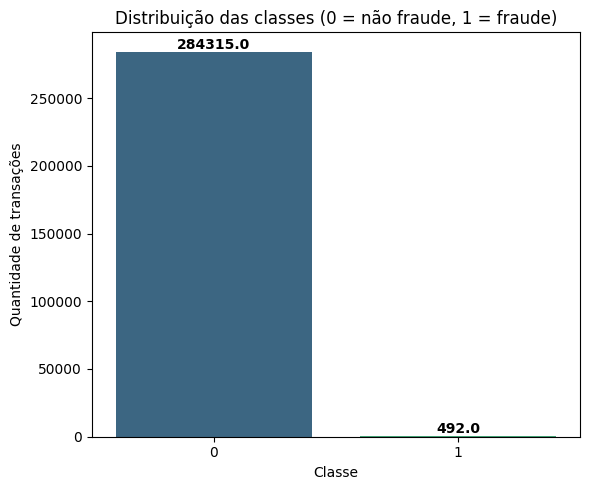

In [8]:
# Distribuição das classes
# Cria um gráfico de barras mostrando a quantidade de transações por classe
# (0 = não fraude, 1 = fraude).
# Útil para visualizar o desbalanceamento do dataset e confirmar a baixa proporção de fraudes.
# Os números exatos de casos são exibidos no topo de cada barra.

plt.figure(figsize=(6,5))
ax = sns.countplot(x='class', data=dataset, palette="viridis")
plt.title("Distribuição das classes (0 = não fraude, 1 = fraude)")
plt.xlabel("Classe")
plt.ylabel("Quantidade de transações")

# Adicionar valores exatos em cima das barras
for p in ax.patches:
    ax.annotate(str(p.get_height()), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10, fontweight='bold', rotation=0)

plt.tight_layout()
plt.show()

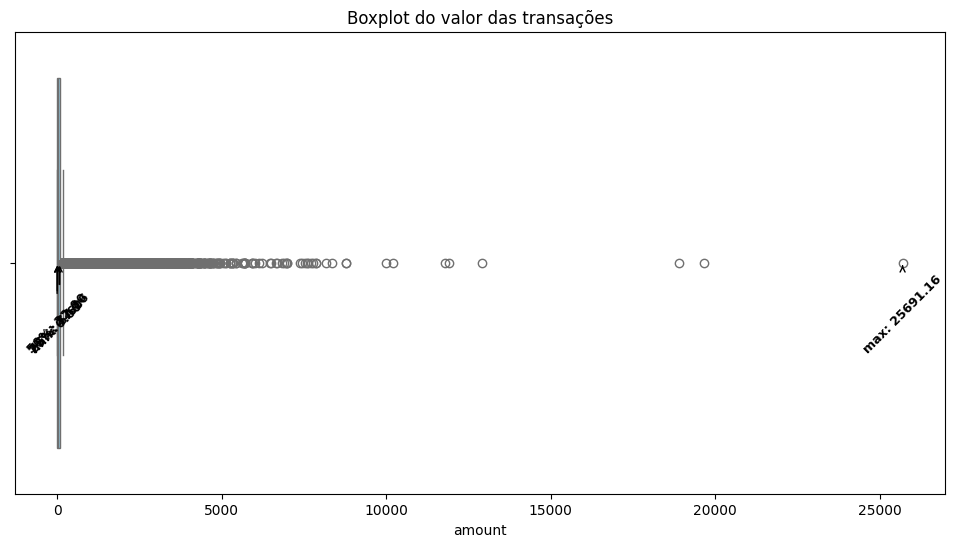

In [9]:
# Boxplot do valor das transações
# Mostra a distribuição dos valores das transações, destacando concentração em valores baixos e presença de outliers.
# Além do boxplot, adiciona os principais valores estatísticos (mínimo, quartis e máximo) diretamente no gráfico.

plt.figure(figsize=(12,6))
ax = sns.boxplot(x=dataset['amount'], color="skyblue")
plt.title("Boxplot do valor das transações")

# Calcular estatísticas descritivas
stats = dataset['amount'].describe()

# Adicionar valores estatísticos no gráfico
for stat_name, stat_value in stats[['min','25%','50%','75%','max']].items():
    ax.annotate(f"{stat_name}: {stat_value:.2f}",
                xy=(stat_value, 0),
                xytext=(stat_value, 0.2),
                textcoords='data',
                ha='center', va='bottom',
                fontsize=9, fontweight='bold',
                rotation=45,
                arrowprops=dict(arrowstyle="->", color="black"))

plt.show()

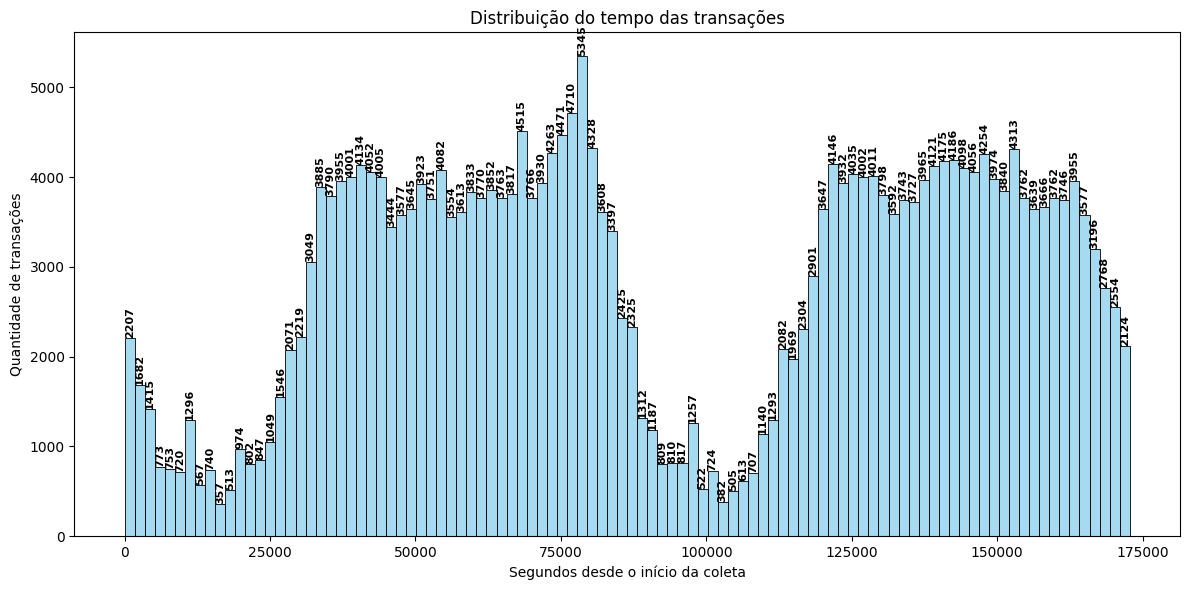

In [10]:
# Distribuição do tempo das transações
# Cria um histograma para visualizar a frequência de transações ao longo do tempo (em segundos).
# Útil para identificar picos de atividade, padrões temporais e possíveis concentrações de transações.
# O gráfico foi ajustado com estilo consistente e contagem exata no topo de cada barra.

plt.figure(figsize=(12,6))
ax = sns.histplot(dataset['time'], bins=100, kde=False, color="skyblue")
plt.title("Distribuição do tempo das transações")
plt.xlabel("Segundos desde o início da coleta")
plt.ylabel("Quantidade de transações")

# Adicionar valores exatos no topo de cada barra
for patch in ax.patches:
    height = patch.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}',
                    (patch.get_x() + patch.get_width() / 2, height),
                    ha='center', va='bottom',
                    fontsize=8, fontweight='bold', rotation=90)

plt.tight_layout()
plt.show()

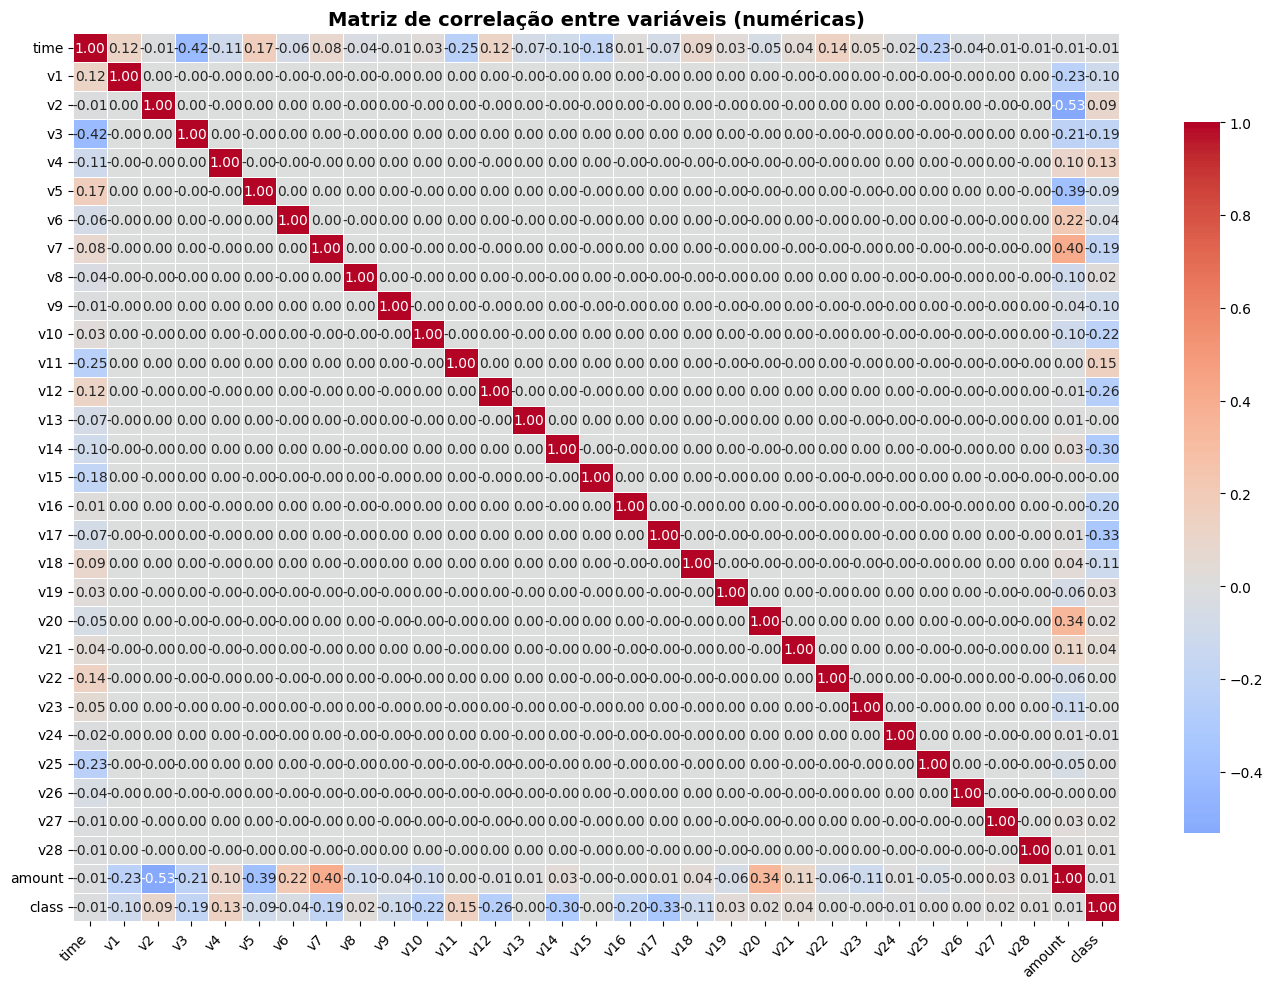

In [11]:
# Matriz de correlação entre variáveis (somente numéricas)
# Remove colunas não numéricas (como 'periodo') e calcula a correlação apenas entre variáveis numéricas.
# Útil para identificar relações lineares entre atributos quantitativos e a variável alvo (class).

plt.figure(figsize=(14,10))

# Seleciona apenas colunas numéricas
corr = dataset.select_dtypes(include=['number']).corr()

# Heatmap com valores anotados
sns.heatmap(corr, cmap="coolwarm", center=0, annot=True, fmt=".2f",
            linewidths=0.5, cbar_kws={"shrink": 0.8})

plt.title("Matriz de correlação entre variáveis (numéricas)", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

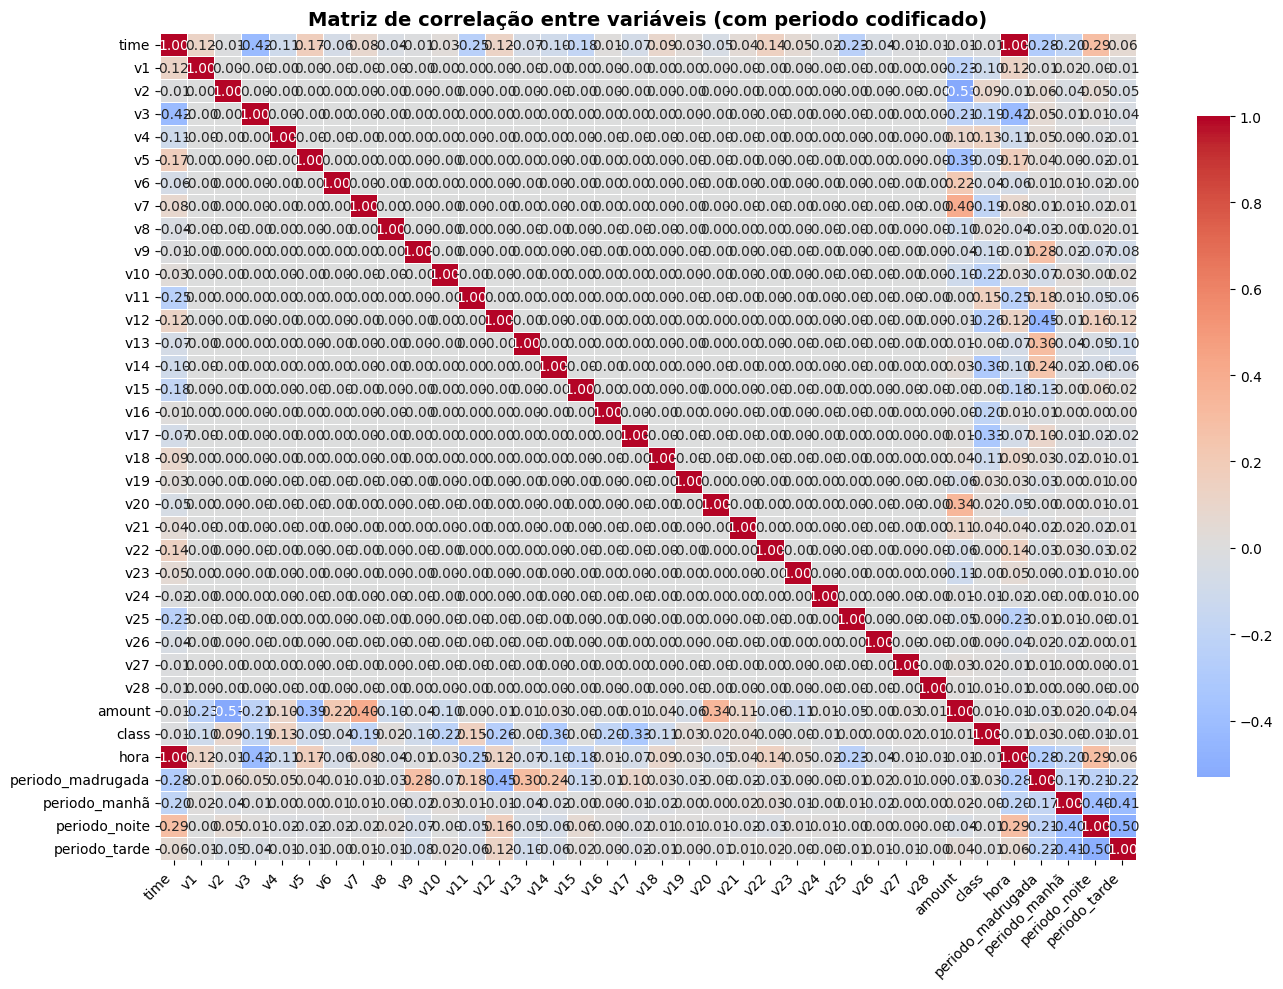

In [12]:
# Criar coluna 'periodo' a partir da hora
dataset['hora'] = dataset['time'] / 3600

def periodo_do_dia(hora):
    hora = int(hora % 24)  # ciclo de 24h
    if 6 <= hora < 12:
        return 'manhã'
    elif 12 <= hora < 18:
        return 'tarde'
    elif 18 <= hora < 24:
        return 'noite'
    else:
        return 'madrugada'

dataset['periodo'] = dataset['hora'].apply(periodo_do_dia)

# Converte 'periodo' em variáveis binárias (One-Hot Encoding)
dataset_encoded = pd.get_dummies(dataset, columns=['periodo'])

plt.figure(figsize=(14,10))
corr = dataset_encoded.corr()

sns.heatmap(corr, cmap="coolwarm", center=0, annot=True, fmt=".2f",
            linewidths=0.5, cbar_kws={"shrink": 0.8})

plt.title("Matriz de correlação entre variáveis (com periodo codificado)", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

C:\Users\Aquiles\AppData\Local\Temp\ipykernel_22468\2626905918.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=horas.index, y=horas.values, palette="viridis")


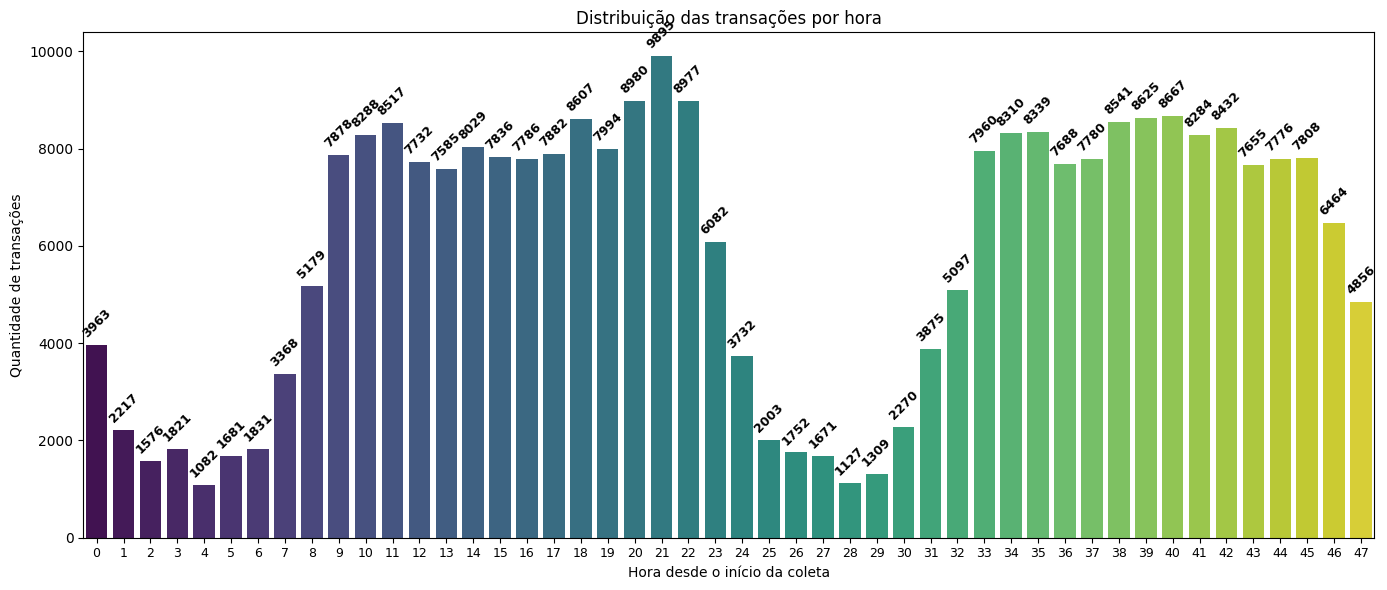

In [13]:
# Distribuição das transações por hora
# Converte o tempo de segundos para horas e agrupa por hora inteira.
# Mostra em gráfico de barras o volume de transações ao longo das 48 horas de coleta.
# Útil para identificar picos de atividade e padrões temporais.
# Os números exatos de transações são exibidos no topo de cada barra.
# Converter tempo para horas
dataset['hora'] = dataset['time'] / 3600

# Agrupar por hora inteira
dataset['hora_inteira'] = dataset['hora'].astype(int)
horas = dataset['hora_inteira'].value_counts().sort_index()

# Plotar gráfico de barras
plt.figure(figsize=(14,6))
sns.barplot(x=horas.index, y=horas.values, palette="viridis")
plt.title("Distribuição das transações por hora")
plt.xlabel("Hora desde o início da coleta")
plt.ylabel("Quantidade de transações")

# Adicionar número exato de transações no topo de cada barra com rotação
for i, val in enumerate(horas.values):
    plt.text(i, val + 100, str(val), ha='center', va='bottom', fontsize=9, fontweight='bold', rotation=45)

plt.xticks(rotation=0, fontsize=9)  # mantém as horas na horizontal
plt.tight_layout()
plt.show()

C:\Users\Aquiles\AppData\Local\Temp\ipykernel_22468\3025342521.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=periodos.index, y=periodos.values, palette="viridis")


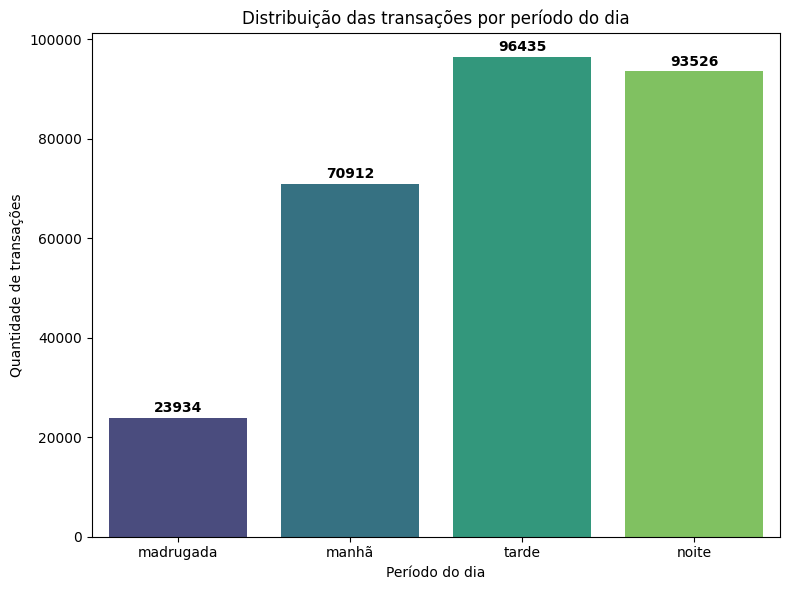

In [14]:
# Distribuição das transações por período do dia
# Converte o tempo em horas e classifica em ciclos de 24h (madrugada, manhã, tarde, noite).
# Cria uma nova coluna 'periodo' e conta a quantidade de transações em cada faixa.
# Útil para identificar padrões de atividade em diferentes períodos do dia.
# Os valores exatos são exibidos no topo de cada barra.

# Converter segundos em horas
dataset['hora'] = dataset['time'] / 3600

# Função para categorizar períodos do dia
def periodo_do_dia(hora):
    hora = int(hora % 24)  # ciclo de 24h
    if 6 <= hora < 12:
        return 'manhã'
    elif 12 <= hora < 18:
        return 'tarde'
    elif 18 <= hora < 24:
        return 'noite'
    else:
        return 'madrugada'

# Criar coluna de período
dataset['periodo'] = dataset['hora'].apply(periodo_do_dia)

# Contar transações por período
periodos = dataset['periodo'].value_counts().reindex(['madrugada','manhã','tarde','noite'])

# Plotar gráfico
plt.figure(figsize=(8,6))
sns.barplot(x=periodos.index, y=periodos.values, palette="viridis")
plt.title("Distribuição das transações por período do dia")
plt.xlabel("Período do dia")
plt.ylabel("Quantidade de transações")

# Adicionar valores exatos em cima das barras
for i, val in enumerate(periodos.values):
    plt.text(i, val + 500, str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

In [15]:
# ============================================================
#                PASSO 2 — PRÉ-PROCESSAMENTO
# ============================================================

# O pré-processamento prepara o dataset para que o modelo aprenda de forma correta, eliminando 
# problemas como escalas diferentes, dados extremos e desbalanceamento. No nosso caso, serão aplicados os seguintes processos:
# ============================================================

# 2.1 — Verificação de valores ausentes
# 2.2 — Tratamento de valores ausentes
# 2.3 — Normalização (padronização) das colunas "amount" e "time"
# 2.4 — Remoção de outliers
# 2.5 — Balanceamento das classes
# 2.6 — Separação final em treino e testes
# ============================================================

In [16]:
#2.1 - Verificar valores ausentes
print("Valores ausentes por coluna:")
print(dataset.isnull().sum())

Valores ausentes por coluna:
time            0
v1              0
v2              0
v3              0
v4              0
v5              0
v6              0
v7              0
v8              0
v9              0
v10             0
v11             0
v12             0
v13             0
v14             0
v15             0
v16             0
v17             0
v18             0
v19             0
v20             0
v21             0
v22             0
v23             0
v24             0
v25             0
v26             0
v27             0
v28             0
amount          0
class           0
hora            0
periodo         0
hora_inteira    0
dtype: int64


In [17]:
#2.2 - Remove linhas com valores ausentes (caso existam)
dataset = dataset.dropna()
print("\nApós remoção de valores ausentes:", dataset.shape)


Após remoção de valores ausentes: (284807, 34)


In [18]:
# 2.3 — Normalização das colunas Amount e Time

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#Esse objeto calcula:
#média da coluna
#desvio padrão
#e transforma os valores usando a função z = (x - média) / desvio padrão

dataset[['amount_scaled', 'time_scaled']] = scaler.fit_transform(dataset[['amount', 'time']])
#média = 0
#desvio padrão = 1
#deixam o dataset mais adequado para treinar

print("\nColunas normalizadas adicionadas (amount_scaled, time_scaled).")
#Agora o dataset possui:
#amount_scaled
#time_scaled
#otal de 33 colunas agora.


Colunas normalizadas adicionadas (amount_scaled, time_scaled).


In [19]:
# 2.4 — Remover outliers da coluna 'amount'
# O dataset tem transações com valores muito altos, removemos extremos
# usando a técnica IQR (Intervalo Inter-Quartil).
Q1 = dataset['amount'].quantile(0.25)
Q3 = dataset['amount'].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

dataset = dataset[
    (dataset['amount'] >= limite_inferior) &
    (dataset['amount'] <= limite_superior)
]

print("\nApós remoção de outliers:", dataset.shape)


Após remoção de outliers: (252903, 36)


In [20]:
# 2.5 - Balanceamento das classes com SMOTE
# O dataset é extremamente desbalanceado (fraudes ≈ 0.17%)

from imblearn.over_sampling import SMOTE

# Separar atributos (X) e rótulo (y)
# Removemos 'class' (alvo) e 'periodo' (categórica) para evitar erro no SMOTE
X = dataset.drop(['class', 'periodo'], axis=1)
y = dataset['class']

# O SMOTE cria novos exemplos sintéticos da classe minoritária (fraudes),
# usando interpolação entre vizinhos próximos. Isso evita overfitting e
# deixa as duas classes com o mesmo número de amostras.
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Mostrar distribuição antes e depois do balanceamento
print("\nDistribuição antes do SMOTE:")
print(y.value_counts())

print("\nDistribuição depois do SMOTE:")
print(y_resampled.value_counts())


Distribuição antes do SMOTE:
class
0    252502
1       401
Name: count, dtype: int64

Distribuição depois do SMOTE:
class
0    252502
1    252502
Name: count, dtype: int64


In [21]:
# 2.6 — Separar os dados em treino e teste
# Usamos 80% para treino e 20% para teste

# Até aqui aplicamos SMOTE, então o dataset ficou balanceado:
# Classe 0 → 234.554
# Classe 1 → 234.554
# Total após SMOTE = 469.108 registros (aproximadamente)
#
# Depois dividimos os dados em:
# 80% para TREINO - modelo aprende
# 20% para TESTE  - modelo é avaliado
#
# OBS: os valores finais podem variar um pouco porque o SMOTE
# cria amostras sintéticas usando vizinhos próximos.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.2,
    random_state=42
)

print("\nTamanho do conjunto de treino:", X_train.shape)
print("Tamanho do conjunto de teste:", X_test.shape)


Tamanho do conjunto de treino: (404003, 34)
Tamanho do conjunto de teste: (101001, 34)


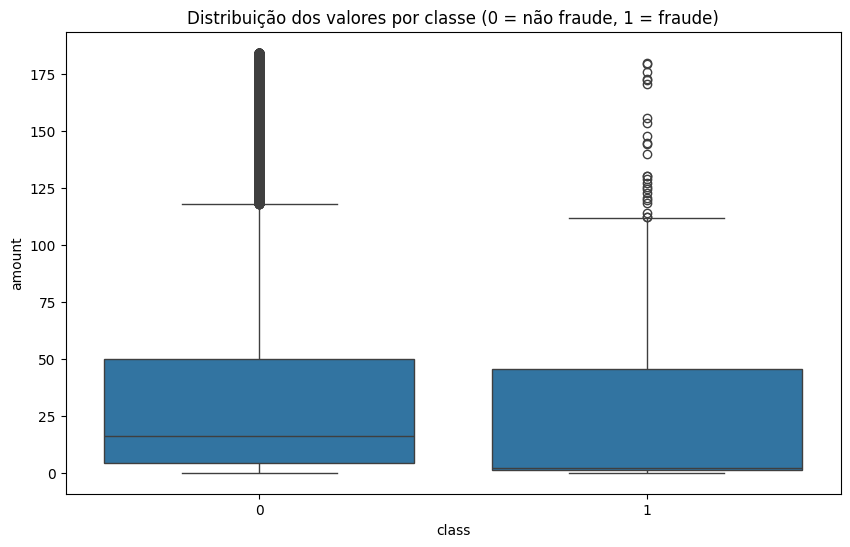

In [22]:
# Boxplot dos valores por classe
# Verifica se os outliers da coluna 'amount' estão associados à classe de fraude.
# A análise mostra que os valores extremos estão majoritariamente na classe 0 (não fraude),
# indicando que os outliers não representam transações fraudulentas.
# Portanto, a remoção desses outliers foi considerada adequada para reduzir ruído sem
# comprometer a detecção de fraudes.

plt.figure(figsize=(10,6))
sns.boxplot(x='class', y='amount', data=dataset)
plt.title("Distribuição dos valores por classe (0 = não fraude, 1 = fraude)")
plt.show()

In [23]:
# ============================================
# 3. MODELAGEM — Treinamento de dois algoritmos
# ============================================


# MODELO 1: KNN (K-Nearest Neighbors)
# MODELO 2: ÁRVORE DE DECISÃO (Decision Tree)
# MODELO 3: Random Forest

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, cross_val_score
import matplotlib.pyplot as plt
import pandas as pd

# ========================================================
# MODELO 1: KNN
# ========================================================

# --------------------------------------------------------
# O KNN classifica uma transação verificando os vizinhos
# mais próximos no espaço de atributos. É simples e serve
# como baseline para comparar com outros modelos.
# ========================================================


knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
y_proba_knn = knn.predict_proba(X_test)[:,1]

print("\n===== RESULTADOS DO MODELO KNN =====")
print("Acurácia:", accuracy_score(y_test, y_pred_knn))
print("ROC AUC:", roc_auc_score(y_test, y_proba_knn))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred_knn))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred_knn))

# ========================================================
#Precisão 96% das transações marcadas como fraude estavam realmente corretas.
#Recall 97% das fraudes reais.
#F1 97% equilíbrio entre precisão e recall.



===== RESULTADOS DO MODELO KNN =====
Acurácia: 0.9662379580400194
ROC AUC: 0.9924532206513799

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97     50611
           1       0.96      0.97      0.97     50390

    accuracy                           0.97    101001
   macro avg       0.97      0.97      0.97    101001
weighted avg       0.97      0.97      0.97    101001

Matriz de Confusão:
 [[48626  1985]
 [ 1425 48965]]


In [ ]:
# MODELO 2: ÁRVORE DE DECISÃO (Decision Tree)
# A árvore de decisão cria regras de decisão para classificar
# cada transação. É rápida, interpretável e eficiente.


tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
y_proba_tree = tree.predict_proba(X_test)[:,1]

print("\n===== RESULTADOS DO MODELO DECISION TREE =====")
print("Acurácia:", accuracy_score(y_test, y_pred_tree))
print("ROC AUC:", roc_auc_score(y_test, y_proba_tree))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred_tree))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred_tree))

#Acurácia 99,85%. 
#Modelo muito bom para detectar fraudes com alta precisão e recall.
#F1 99,85% equilíbrio entre precisão e recall.




===== RESULTADOS DO MODELO DECISION TREE =====
Acurácia: 0.9989109018722587
ROC AUC: 0.9989120665256241

Relatório de Classificação:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     50611
           1       1.00      1.00      1.00     50390

    accuracy                           1.00    101001
   macro avg       1.00      1.00      1.00    101001
weighted avg       1.00      1.00      1.00    101001

Matriz de Confusão:
 [[50529    82]
 [   28 50362]]


In [ ]:
# MODELO 3: Random Forest

# Árvores de decisão treinadas com amostras/atributos distintos.
# Geralmente reduz overfitting da árvore única e é muito eficaz em dados tabulares.


rf = RandomForestClassifier(
    n_estimators=100,       # reduz número de árvores
    min_samples_leaf=10,    # folhas maiores, menos complexidade
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]

print("\n===== RESULTADOS DO MODELO RANDOM FOREST =====")
print("Acurácia:", accuracy_score(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred_rf))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred_rf))

#Acurácia 99,92%.
#ROC AUC 99,98% excelente capacidade de distinguir fraudes.
#O AUC mede a capacidade do modelo de separar fraudulento vs não-fraudulento independentemente de limiar
#F1 99,92% equilíbrio entre precisão e recall.
#Dataset muito bem modelado com Random Forest.



===== RESULTADOS DO MODELO RANDOM FOREST =====
Acurácia: 0.999841585726874
ROC AUC: 0.9999822376943902

Relatório de Classificação:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     50611
           1       1.00      1.00      1.00     50390

    accuracy                           1.00    101001
   macro avg       1.00      1.00      1.00    101001
weighted avg       1.00      1.00      1.00    101001

Matriz de Confusão:
 [[50597    14]
 [    2 50388]]


In [ ]:
# =============================================================
# 5. Comparação 
# =============================================================

# Nesta etapa, comparamos os três modelos aplicados: KNN, Decision Tree e Random Forest, avaliando desempenho
# limitações, robustez e aplicabilidade no contexto de detecção de fraudes. A análise considera não apenas métricas quantitativas
# mas também aspectos conceituais importantes para uso real em produção.

# Os três modelos apresentaram bons resultados, porém o Random Forest demonstrou
# superioridade em praticamente todas as métricas, além de ser mais estável e robusto. 
# O modelo é altamente eficaz para o cenário proposto de detecção de fraudes, embora melhorias adicionais possam tornar a solução ainda mais precisa e generalizável.
# =============================================================

In [27]:
# Importância de features
importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("\nTop 10 features por importância:\n", importances.head(10))

# ========================================================
# Validação cruzada com 3 folds (Random Forest otimizado)
# ========================================================
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scores = cross_val_score(rf, X_resampled, y_resampled, cv=cv, scoring='f1')
print("\nF1 médio (Random Forest, CV=3):", scores.mean())

# ========================================================



Top 10 features por importância:
 v14    0.162573
v12    0.123434
v10    0.121206
v4     0.099883
v11    0.086760
v17    0.080220
v3     0.060533
v7     0.056262
v16    0.038650
v2     0.026790
dtype: float64

F1 médio (Random Forest, CV=3): 0.9997743041641223


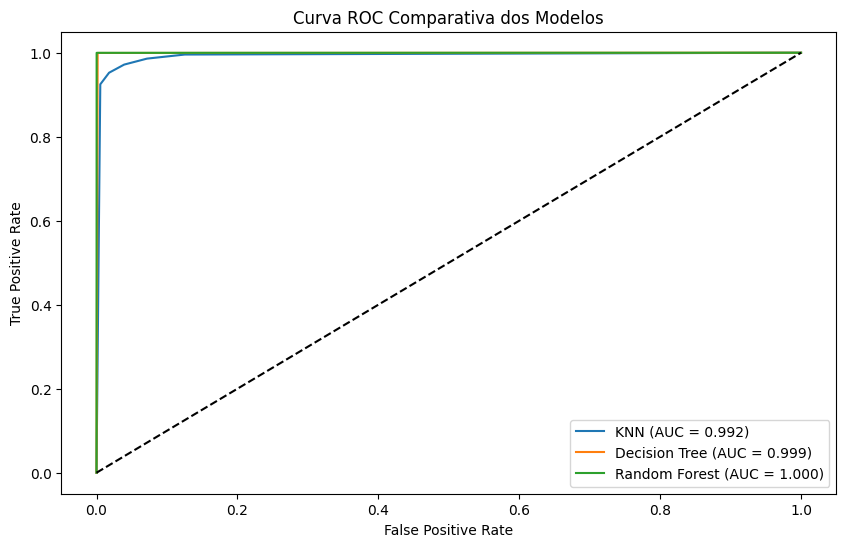

In [28]:
# Curva ROC comparativa
# ========================================================
plt.figure(figsize=(10,6))

fpr_knn, tpr_knn, _ = roc_curve(y_test, y_proba_knn)
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_proba_tree)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.plot(fpr_knn, tpr_knn, label=f"KNN (AUC = {roc_auc_score(y_test, y_proba_knn):.3f})")
plt.plot(fpr_tree, tpr_tree, label=f"Decision Tree (AUC = {roc_auc_score(y_test, y_proba_tree):.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_score(y_test, y_proba_rf):.3f})")

plt.plot([0,1],[0,1],'k--')  # linha diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC Comparativa dos Modelos")
plt.legend()
plt.show()


In [ ]:
# Comparação final em tabela
# ========================================================

# - MODELO 3: Random Forest é o melhor modelo entre os três, com quase 100% de acurácia, recall e precisão.
# - Modelo extremamente robusto e confiável

# - MODELO 2: ÁRVORE DE DECISÃO - também teve desempenho excelente, porém, pode estar um pouco especialista demais (overfitting leve).

# - MODELO 1: KNN (K-Nearest Neighbors) funciona, mas é inferior e menos escalável, funciona comparando cada amostra com seus vizinhos mais próximos.


comparacao = pd.DataFrame({
    "Modelo": ["KNN", "Decision Tree", "Random Forest"],
    "Acurácia": [
        accuracy_score(y_test, y_pred_knn),
        accuracy_score(y_test, y_pred_tree),
        accuracy_score(y_test, y_pred_rf)
    ],
    "ROC AUC": [
        roc_auc_score(y_test, y_proba_knn),
        roc_auc_score(y_test, y_proba_tree),
        roc_auc_score(y_test, y_proba_rf)
    ],
    "Resumo": [
        "Bom, mas mais fraco e lento em grandes bases",
        "Excelente, mas pode sobreajustar",
        "Melhor modelo, quase nenhuma fraude perdida"
    ]
})

print("\nComparação final:\n", comparacao)



Comparação final:
           Modelo  Acurácia   ROC AUC  \
0            KNN  0.966238  0.992453   
1  Decision Tree  0.998911  0.998912   
2  Random Forest  0.999842  0.999982   

                                         Resumo  
0  Bom, mas mais fraco e lento em grandes bases  
1              Excelente, mas pode sobreajustar  
2   Melhor modelo, quase nenhuma fraude perdida  


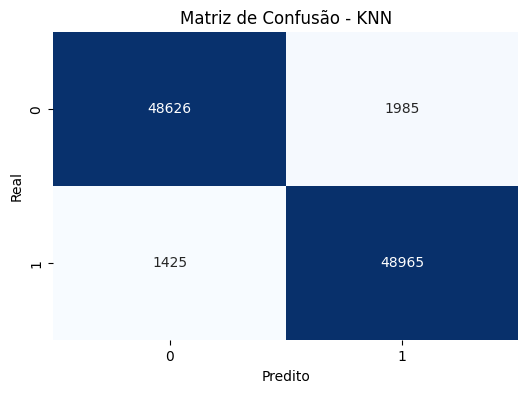

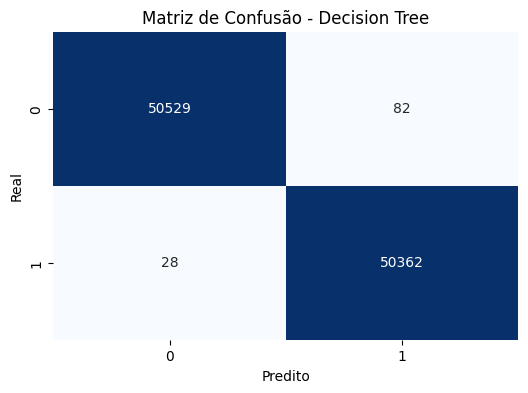

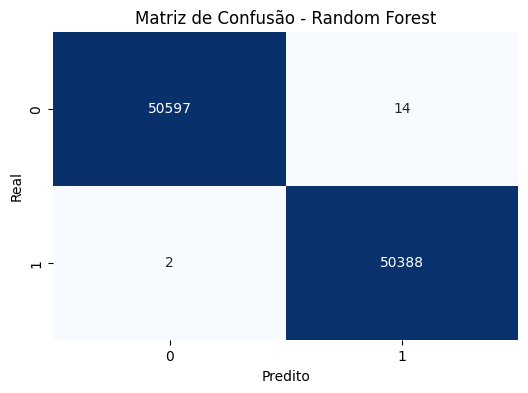

In [ ]:
# As matrizes de confusão permitem avaliar visualmente os acertos e erros de cada modelo.
# Elas mostram quantas transações legítimas (classe 0) e fraudulentas (classe 1) foram
# corretamente classificadas (diagonal principal) e quantas foram confundidas (fora da diagonal).
# Esse tipo de gráfico complementa as métricas numéricas (acurácia, precisão, recall, F1, ROC AUC),
# oferecendo uma visão intuitiva da capacidade dos modelos em distinguir fraude vs não fraude.

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Função para plotar matriz de confusão
def plot_confusion_matrix(y_true, y_pred, titulo):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.title(titulo)
    plt.show()

# Matriz de confusão para cada modelo
plot_confusion_matrix(y_test, y_pred_knn, "Matriz de Confusão - KNN")
plot_confusion_matrix(y_test, y_pred_tree, "Matriz de Confusão - Decision Tree")
plot_confusion_matrix(y_test, y_pred_rf, "Matriz de Confusão - Random Forest")

c:\Users\Aquiles\Downloads\Big Data\Trabalho 02\CREDIT\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:23:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



===== RESULTADOS DO MODELO XGBOOST =====
Acurácia: 0.9998118830506628
ROC AUC: 0.9999862701796746

Relatório de Classificação:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     50611
           1       1.00      1.00      1.00     50390

    accuracy                           1.00    101001
   macro avg       1.00      1.00      1.00    101001
weighted avg       1.00      1.00      1.00    101001

Matriz de Confusão:
 [[50592    19]
 [    0 50390]]


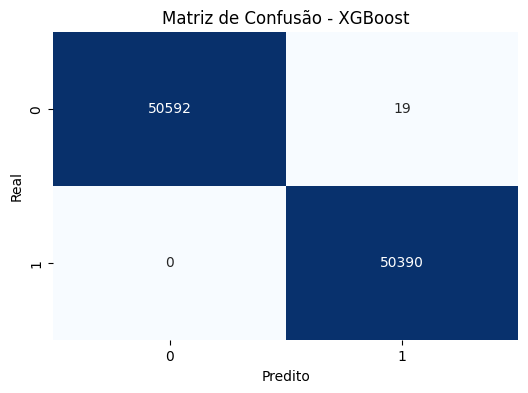

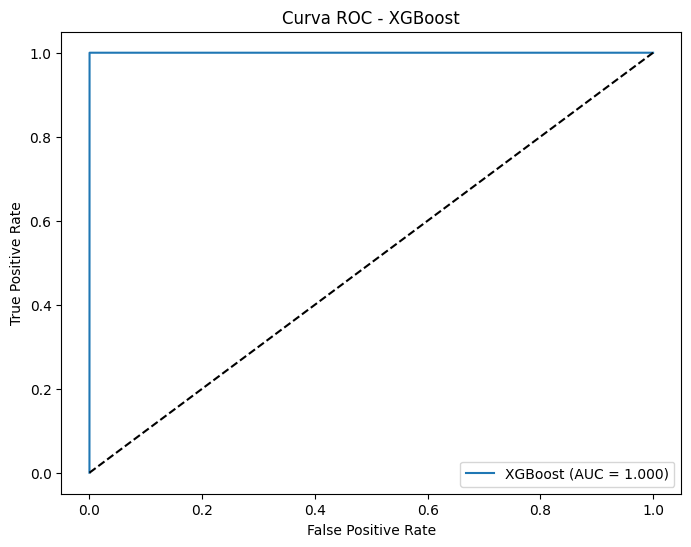


Top 10 features por importância (XGBoost):
 v14    0.586675
v10    0.133879
v4     0.039570
v12    0.025803
v17    0.021323
v28    0.014187
v8     0.011929
v11    0.011236
v3     0.010566
v1     0.010337
dtype: float32


In [ ]:
# Como melhoria implementamos um algoritmo mais avançado: XGBoost, resultando nos dados abaixo:

# ========================================================
# MODELO 4: XGBoost
# ========================================================
# O XGBoost é um algoritmo de boosting baseado em árvores de decisão.
# Ele constrói várias árvores sequenciais, onde cada nova árvore corrige
# os erros da anterior. É altamente eficiente e costuma ter desempenho
# superior em problemas de classificação tabular.

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1) Instanciar o modelo com hiperparâmetros básicos
xgb = XGBClassifier(
    n_estimators=200,        # número de árvores
    learning_rate=0.1,       # taxa de aprendizado
    max_depth=6,             # profundidade máxima das árvores
    subsample=0.8,           # fração de amostras usadas em cada árvore
    colsample_bytree=0.8,    # fração de atributos usados em cada árvore
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric="logloss"    # evita warnings
)

# 2) Treinar o modelo
xgb.fit(X_train, y_train)

# 3) Fazer previsões
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:,1]

# 4) Avaliar desempenho com métricas
print("\n===== RESULTADOS DO MODELO XGBOOST =====")
print("Acurácia:", accuracy_score(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, y_proba_xgb))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred_xgb))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred_xgb))

# 5) Plotar matriz de confusão
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6,4))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão - XGBoost")
plt.show()

# 6) Curva ROC exclusiva do XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
plt.figure(figsize=(8,6))
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_auc_score(y_test, y_proba_xgb):.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - XGBoost")
plt.legend()
plt.show()

# 7) Importância das features
importances_xgb = pd.Series(xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("\nTop 10 features por importância (XGBoost):\n", importances_xgb.head(10))


In [ ]:
# Comparação de métricas entre os quatro modelos implementados: KNN, Decision Tree, Random Forest e XGBoost. 
import pandas as pd

# Criar DataFrame com métricas comparativas
comparacao = pd.DataFrame({
    "Modelo": ["KNN", "Decision Tree", "Random Forest", "XGBoost"],
    "Acurácia": [
        accuracy_score(y_test, y_pred_knn),
        accuracy_score(y_test, y_pred_tree),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb)
    ],
    "ROC AUC": [
        roc_auc_score(y_test, y_proba_knn),
        roc_auc_score(y_test, y_proba_tree),
        roc_auc_score(y_test, y_proba_rf),
        roc_auc_score(y_test, y_proba_xgb)
    ],
})

print("\nTabela comparativa de métricas:\n")
print(comparacao)


Tabela comparativa de métricas:

          Modelo  Acurácia   ROC AUC
0            KNN  0.966238  0.992453
1  Decision Tree  0.998911  0.998912
2  Random Forest  0.999842  0.999982
3        XGBoost  0.999812  0.999986
